# Customer Churn Prediction

## Problem Statement and Strategy
The goal of this analysis is to build a model to predict whether the customers churned in the given period. In this report we consider three models: the logistic regression, random forest, and balanced bagging classifier.

## Data Preparation and EDA

### Import the libraries and load the file as a DataFrame

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

To simplify our collaboration on the project, we upload the file to github and load it as a data frame.

In [ ]:
url = 'https://raw.githubusercontent.com/SGene-hub/Churn/main/telco_customer_churn.csv'
df = pd.read_csv (url)
df.head()

,customer_ID,gender,senior_citizen,partner,dependents,tenure,phone_Service,multiple_lines,internet,security_online,backup_online,device_protection,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_mode,charges_per_month,charges_total,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The resulting data frame contains 21 columns and 7043 rows.

In [ ]:
df.shape

(7043, 21)

### Drop unnecessary columns
We can safely remove the *customerID* column from the analysis, as it does not offer any predictive benefit.

In [ ]:
df.drop(['customer_ID'],axis=1,inplace=True)

### Check for missing values
Now let us check for the presence of any missing values in our data set.

In [ ]:
df.isnull().sum()

gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_Service        0
multiple_lines       0
internet             0
security_online      0
backup_online        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract_type        0
paperless_billing    0
payment_mode         0
charges_per_month    0
charges_total        0
churn                0
dtype: int64

As we can see, there are no NaN values to be concerned about. Note that this does not necessarily mean that missing values aren't present at all - they could just be coded differently.

### Check and change column types to avoid surprises later on
Now let us check column types:


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_Service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet           7043 non-null   object 
 8   security_online    7043 non-null   object 
 9   backup_online      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract_type      7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_mode       7043 

One of the first things we notice is that the *charges_total* variable is type *object*, while we expect it to be of type *float*. At first when we try to change its type we run into errors. We discover that the source of the error is the presence of empty space strings intead of missing values in the column. For this reason we change those values to NaN, perform the type change and drop the missing values from the data set. 

In [ ]:
df['charges_total'].replace(to_replace = ' ', value=np.nan, inplace = True)
df['charges_total'] = df['charges_total'].astype(float)
df.dropna(axis=0, inplace=True)

### Review categories of object variables
To make the data easier to work with in the future, let us check the categories of object variables and modify them where necessary. 

In [ ]:
catagorical = [i for i in df.columns if df[i].dtypes == 'object']

for i in catagorical:   
    print(i, ':', df[i].unique())

gender : ['Female' 'Male' 'Prefer not to say']
partner : ['Yes' 'No']
dependents : ['No' 'Yes']
phone_Service : ['No' 'Yes']
multiple_lines : ['No phone service' 'No' 'Yes']
internet : ['DSL' 'Fiber optic' 'No']
security_online : ['No' 'Yes' 'No internet service']
backup_online : ['Yes' 'No' 'No internet service']
device_protection : ['No' 'Yes' 'No internet service']
tech_support : ['No' 'Yes' 'No internet service']
streaming_tv : ['No' 'Yes' 'No internet service']
streaming_movies : ['No' 'Yes' 'No internet service']
contract_type : ['Month-to-month' 'One year' 'Two year']
paperless_billing : ['Yes' 'No']
payment_mode : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
churn : ['No' 'Yes']


We notice that the number of columns varies from 2 to 4 and that "No phone service" and "No internet service" can be simply changed to "No" since this information is already contained in the *phone_Service* and *internet* columns.

In [ ]:
df = df.replace(regex=r'No\s[a-z]+\sservice', value='No')

Now we can encode the "Yes" answers as 1 and "No" answers as 0. Moreover, since there are only 6 observations with gender as "Prefer not to say, we can drop them from the data set and encode "Male" as 1 and "Female" as 0. 

In [ ]:
df = df[(df['gender'] != 'Prefer not to say')]
df = df[~df['gender'].isnull()]

for i in catagorical:   
    if len(df[i].unique()) == 2:        
        df[i] = df[i].map({'Male': 1, 'Female': 0 ,'Yes': 1, 'No': 0})

Moving on the the rest, we try to see if we can make the categorical variables with more than 2 options ordinal. To do this, let us visualise the relationship between these variables and the probability of churning.

[Text(0, 0, 'Electronic check'),
 Text(0, 0, 'Mailed check'),
 Text(0, 0, 'Bank transfer'),
 Text(0, 0, 'Credit card')]

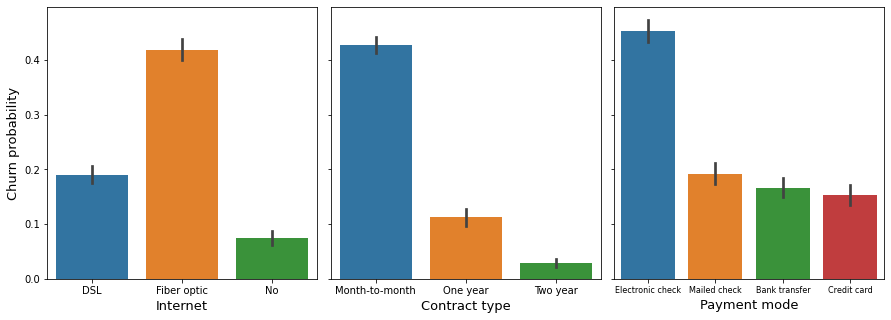

In [ ]:
df['payment_mode']=df['payment_mode'].replace({'Bank transfer (automatic)': 'Bank transfer', 'Credit card (automatic)': 'Credit card'})

figure, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plot1 = sns.barplot(ax=axes[0], x="internet",y="churn",data=df)
plot1.set_xlabel("Internet", fontsize=13)
plot1.set_ylabel("Churn probability", fontsize=13)

plot2 = sns.barplot(ax=axes[1], x="contract_type",y="churn",data=df)
plot2.set_xlabel("Contract type", fontsize=13)
plot2.set_ylabel('')

plot3 = sns.barplot(ax=axes[2], x="payment_mode",y="churn",data=df)
plot3.set_xlabel("Payment mode", fontsize=13)
plot3.set_ylabel('')
plot3.set_xticklabels(labels=df.payment_mode.unique(), fontsize=8)

[Text(0, 0, 'Senior costumers'), Text(0, 0, 'Not senior costumers')]

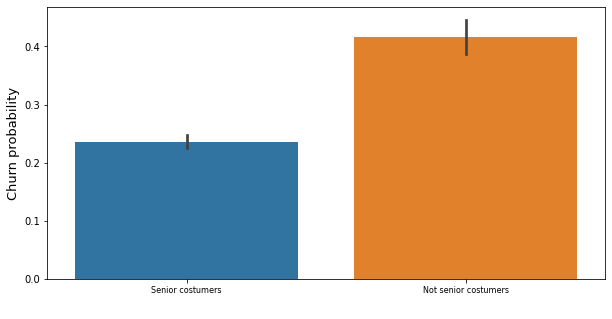

In [ ]:
figure, ax = plt.subplots(1, figsize=(10, 5))

plot1 = sns.barplot(ax=ax, x="senior_citizen",y="churn",data=df)
plot1.set_xlabel(" ", fontsize=13)
plot1.set_ylabel("Churn probability", fontsize=13)
plot1.set_xticklabels(labels= ['Senior costumers','Not senior costumers'], fontsize=8)


As we can see, there is a rather clear ordering to the categories with respect to churn probability. In the case of the first two, we can have 3 encodings, and in the last case we can do away with having just two, since only electronic check seems to clearly stick out. 

In [ ]:
internet_cats = df.internet.unique()
internet_dict = dict(zip(internet_cats, [1, 2, 0]))
df.internet = df.internet.map(internet_dict)

contract_cats = df.contract_type.unique()
contract_dict = dict(zip(contract_cats, [2, 1, 0]))
df.contract_type = df.contract_type.map(contract_dict)

payment_cats = df.payment_mode.unique()
payment_dict = dict(zip(payment_cats, [1, 0, 0, 0]))
df.payment_mode = df.payment_mode.map(payment_dict)

### Tenure vs Probability of Churn
Since we expect tenure to be one of the most important variables, let us visualise its relationship with churn. 




Text(0, 0.5, 'Churn probability')

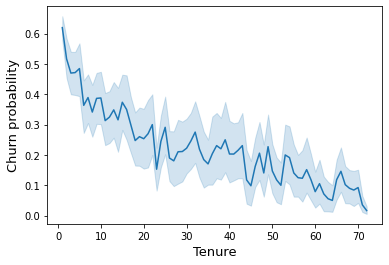

In [ ]:
plot = sns.lineplot(x="tenure", y="churn", data=df)
plot.set_xlabel("Tenure", fontsize=13)
plot.set_ylabel("Churn probability", fontsize=13)

As we see in this plot, there seems to be a clear positive realtionship between the two, with a significant drop in the probability of churn after 6-7 months in particular. 

### Heatmap
Now, let us construct a heatmap of the data to understand it a bit better:

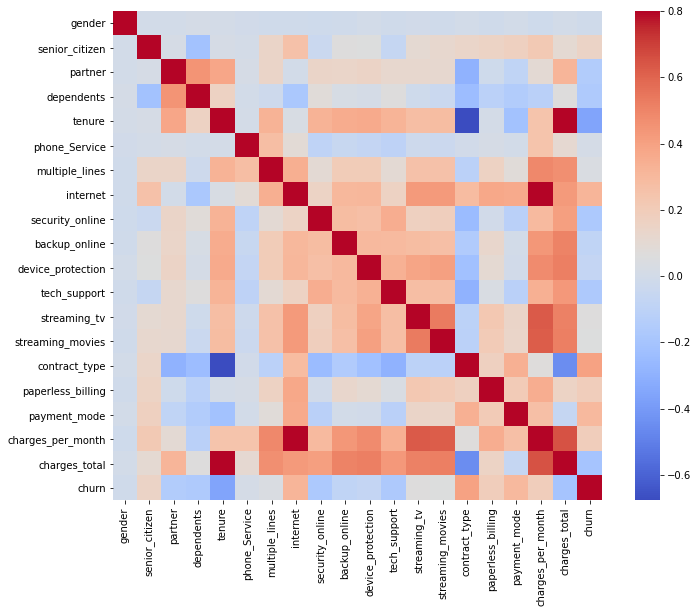

In [ ]:
corrmatrix = df.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmatrix, vmax = 0.8, square = True, cmap = "coolwarm")

We notice that there is obviously a strong positive correlation between *charges_total* and *tenure*, since the *charges_total* variable is a product of *charges_per_month* and *tenure*. There is also a significant positive correlation between the *internet* variable and *charges_per_month*, likely due to the comparatively higher cost of fiber optic. Finally, we take note of the negative correlation between *tenure* and *contract_type*, which makes sense, since long-time customers are less likely to be on the month-to-month plan. 

Examining the relationship between *churn* and other variables, the most noteworthy correlation is the one with *tenure*. This comes as no surprise, since the longer the customer stays with the company the less likely they are to churn. 

### Check for imbalance in target variable
Finally, let us check for imbalance in our target variable.

In [ ]:
df['churn'].value_counts()

0    5159
1    1867
Name: churn, dtype: int64

We can clearly observe that the majority of customers did not churn, which makes our target variable imbalanced. Still, it is not severe enough to drastically affect the performance of our model.

### Main takeways
- The data set is mostly clean and therefore needs very little preparation.

- The *tenure* variable has a noticeable negative correlation with *churn*.

- There is class imbalance in the target variable, but not severe enough to warrant concern.


## Logistic Regression
The first model we are using to predict churn is the logistic regression.

### Separate the target variable from independent variables
To start the model bulding process, let us first segregate the target variable and the independent variables.

In [ ]:
y = df['churn']
X = df.loc[:, df.columns != 'churn']

### Split into train and test
Before we start bilding our models, let's split out data set into a train and test set. To make our results reproducible, we set our random state to 1. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Run the regression 

Now we are equiped to run the logistic regression.

In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=400)
log1 = logreg.fit(X_train, y_train)
log1

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### LBFGS estimates

Before proceeding with the evaluation of the model, we calculate the LBFGS estimates for the regressors.

In [ ]:
for i in range(len(X_train.columns)):
  print(X_train.columns[i], ':', pd.DataFrame(log1.coef_)[i])

gender : 0   -0.052614
Name: 0, dtype: float64
senior_citizen : 0    0.355053
Name: 1, dtype: float64
partner : 0    0.152203
Name: 2, dtype: float64
dependents : 0   -0.211057
Name: 3, dtype: float64
tenure : 0   -0.07748
Name: 4, dtype: float64
phone_Service : 0   -0.882312
Name: 5, dtype: float64
multiple_lines : 0    0.246733
Name: 6, dtype: float64
internet : 0    0.757085
Name: 7, dtype: float64
security_online : 0   -0.520191
Name: 8, dtype: float64
backup_online : 0   -0.237998
Name: 9, dtype: float64
device_protection : 0   -0.036588
Name: 10, dtype: float64
tech_support : 0   -0.479032
Name: 11, dtype: float64
streaming_tv : 0    0.24618
Name: 12, dtype: float64
streaming_movies : 0    0.176721
Name: 13, dtype: float64
contract_type : 0    0.346614
Name: 14, dtype: float64
paperless_billing : 0    0.348621
Name: 15, dtype: float64
payment_mode : 0    0.380305
Name: 16, dtype: float64
charges_per_month : 0   -0.005137
Name: 17, dtype: float64
charges_total : 0    0.000482
Name

We obtain p-values for them by reproducing the same model in the Statsmodel library, so as to be able to improve the model by dropping irrelevant regressors.

In [ ]:
coefficients = pd.DataFrame(log1.coef_)

for i in range(len(X_train.columns)):
  print(X_train.columns[i], ':', coefficients[i])

Statslog1 = sm.Logit(y_train,sm.add_constant(X_train), method = 'lbfgs')
result=Statslog1.fit()
print(result.summary2() )

gender : 0   -0.052614
Name: 0, dtype: float64
senior_citizen : 0    0.355053
Name: 1, dtype: float64
partner : 0    0.152203
Name: 2, dtype: float64
dependents : 0   -0.211057
Name: 3, dtype: float64
tenure : 0   -0.07748
Name: 4, dtype: float64
phone_Service : 0   -0.882312
Name: 5, dtype: float64
multiple_lines : 0    0.246733
Name: 6, dtype: float64
internet : 0    0.757085
Name: 7, dtype: float64
security_online : 0   -0.520191
Name: 8, dtype: float64
backup_online : 0   -0.237998
Name: 9, dtype: float64
device_protection : 0   -0.036588
Name: 10, dtype: float64
tech_support : 0   -0.479032
Name: 11, dtype: float64
streaming_tv : 0    0.24618
Name: 12, dtype: float64
streaming_movies : 0    0.176721
Name: 13, dtype: float64
contract_type : 0    0.346614
Name: 14, dtype: float64
paperless_billing : 0    0.348621
Name: 15, dtype: float64
payment_mode : 0    0.380305
Name: 16, dtype: float64
charges_per_month : 0   -0.005137
Name: 17, dtype: float64
charges_total : 0    0.000482
Name

In [ ]:
 X_train1 =  pd.DataFrame(X_train.drop(columns=['gender', 'partner', 'dependents', 'phone_Service', 'multiple_lines', 'internet', 'security_online', 
                                                 'backup_online', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'charges_per_month']))
 X_test1 =  pd.DataFrame(X_test.drop(columns=['gender', 'partner', 'dependents', 'phone_Service', 'multiple_lines', 'internet', 'security_online', 
                                                 'backup_online', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'charges_per_month']))
 
logreg2 = LogisticRegression(solver='lbfgs', max_iter=400)
log2 = logreg2.fit(X_train1, y_train)
log2
for i in range(len(X_train1.columns)):
  print(X_train1.columns[i], ':', pd.DataFrame(log2.coef_)
[i])
  
Statslog2 = sm.Logit(y_train,sm.add_constant(X_train1), method = 'lbfgs')
result=Statslog2.fit()
print(result.summary2() )


senior_citizen : 0    0.511632
Name: 0, dtype: float64
tenure : 0   -0.078384
Name: 1, dtype: float64
contract_type : 0    0.930391
Name: 2, dtype: float64
paperless_billing : 0    0.568007
Name: 3, dtype: float64
payment_mode : 0    0.663287
Name: 4, dtype: float64
charges_total : 0    0.000616
Name: 5, dtype: float64
Optimization terminated successfully.
         Current function value: 0.434041
         Iterations 8
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.247    
Dependent Variable:   churn            AIC:              4892.6167
Date:                 2021-02-21 13:43 BIC:              4939.0553
No. Observations:     5620             Log-Likelihood:   -2439.3  
Df Model:             6                LL-Null:          -3241.1  
Df Residuals:         5613             LLR p-value:      0.0000   
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       8.0000                                      


Model 3 that includes more variables than model 2, but fewer than model 1.

In [ ]:
 X_train2 =  pd.DataFrame(X_train.drop(columns=['gender', 'partner', 'phone_Service', 'backup_online', 'device_protection', 'tech_support', 'tech_support', 'streaming_tv', 'streaming_movies', 'charges_per_month']))
 X_test2 =  pd.DataFrame(X_test.drop(columns=['gender', 'partner', 'phone_Service','backup_online', 'device_protection', 'tech_support', 'tech_support', 'streaming_tv', 'streaming_movies', 'charges_per_month']))
 
logreg3_nopen = LogisticRegression(solver='lbfgs', max_iter=400, penalty = 'none') # to compare p-values with the model from the Statsmodel library, that has no penalty term.
log3_nopen = logreg3_nopen.fit(X_train2, y_train)

logreg3 = LogisticRegression(solver='lbfgs', max_iter=400) # to use to predict
log3 = logreg3.fit(X_train2, y_train)
print(log3)
for i in range(len(X_train2.columns)):
  print(X_train2.columns[i], ':', pd.DataFrame(log3.coef_)[i])
  
Statslog3 = sm.Logit(y_train,sm.add_constant(X_train2), method = 'lbfgs')
 result=Statslog3.fit()
print(result.summary2() )


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
senior_citizen : 0    0.415591
Name: 0, dtype: float64
dependents : 0   -0.456147
Name: 1, dtype: float64
tenure : 0   -0.08039
Name: 2, dtype: float64
multiple_lines : 0    0.246128
Name: 3, dtype: float64
internet : 0    0.603403
Name: 4, dtype: float64
security_online : 0   -0.504772
Name: 5, dtype: float64
contract_type : 0   -0.15361
Name: 6, dtype: float64
paperless_billing : 0    0.311347
Name: 7, dtype: float64
payment_mode : 0    0.561612
Name: 8, dtype: float64
charges_total : 0    0.000381
Name: 9, dtype: float64
Optimization terminated successfully.
         Current function value: 0.421525
         Iterations 8
                          Results: Logit
M

In [ ]:
X_train3 =  pd.DataFrame(X_train.drop(columns=['gender', 'partner', 'phone_Service', 'security_online','charges_total','device_protection','backup_online']))
X_test3 =  pd.DataFrame(X_test.drop(columns=['gender', 'partner', 'phone_Service', 'security_online','charges_total','device_protection','backup_online']))
logreg4= LogisticRegression(solver='lbfgs', max_iter=400)
log4 = logreg4.fit(X_train3, y_train)
print(log4)


for i in range(len(X_train3.columns)):
  print(X_train3.columns[i], ':', pd.DataFrame(log4.coef_)[i])
  
Statslog4 = sm.Logit(y_train,sm.add_constant(X_train3), method = 'lbfgs')
result=Statslog4.fit()
print(result.summary2() )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
senior_citizen : 0    0.309408
Name: 0, dtype: float64
dependents : 0   -0.154659
Name: 1, dtype: float64
tenure : 0   -0.033577
Name: 2, dtype: float64
multiple_lines : 0    0.378323
Name: 3, dtype: float64
internet : 0    1.336907
Name: 4, dtype: float64
tech_support : 0   -0.19964
Name: 5, dtype: float64
streaming_tv : 0    0.532718
Name: 6, dtype: float64
streaming_movies : 0    0.481295
Name: 7, dtype: float64
contract_type : 0    0.681841
Name: 8, dtype: float64
paperless_billing : 0    0.343387
Name: 9, dtype: float64
payment_mode : 0    0.361924
Name: 10, dtype: float64
charges_per_month : 0   -0.021206
Name: 11, dtype: float64
Optimization terminated succes

### Perform prediction on the test set

In [ ]:
y_pred=logreg.predict(X_test)
y_pred2=logreg2.predict(X_test1)
y_pred3=logreg3.predict(X_test2)
y_pred4=logreg4.predict(X_test3)

### Evaluate the models with confusion matrices
We evaluate the preformance of our classification models we constrcut a confusion matrix for each one:

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix2 = metrics.confusion_matrix(y_test, y_pred2)
cnf_matrix3 = metrics.confusion_matrix(y_test, y_pred3)
cnf_matrix4 = metrics.confusion_matrix(y_test, y_pred4)

print("model 1:\n", cnf_matrix)
print("model 2:\n", cnf_matrix2)
print("model 3:\n", cnf_matrix3)
print("model 4:\n", cnf_matrix4)

model 1:
 [[928  92]
 [169 217]]
model 2:
 [[929  91]
 [215 171]]
model 3:
 [[928  92]
 [180 206]]
model 4:
 [[930  90]
 [168 218]]


As we can see, model 1 correctly predicted 928 instances of non-churn and 217 instances of churn, and mistakenly classsified 169 instances as non-churning and 92 instaces as churning. The only model outperforms model 1 is model 4, with 90 false negatives and 168 false positives — a trade off that seems profitable in context of churn, with high acquisition costs.

We can visualise these confusion matrices with the help of matplotlib and seaborn libraries:

Text(0.5, 24.0, 'Actual label')

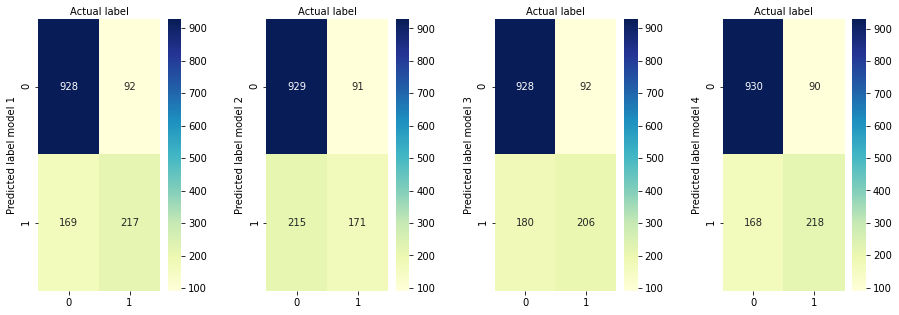

In [ ]:
figure, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15, 5))
plt.subplots_adjust(wspace=0.5, hspace=0.1)
class_names=[0,1]

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plot1 =sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax1)
ax1.xaxis.set_label_position("top")
plot1.set_xlabel('Actual label')
plot1.set_ylabel('Predicted label model 1')


plot2 = sns.heatmap(pd.DataFrame(cnf_matrix2), annot=True, cmap="YlGnBu" ,fmt='g',ax=ax2)
ax2.xaxis.set_label_position("top")

plot2.set_ylabel('Predicted label model 2')
plot2.set_xlabel('Actual label')


plot3 = sns.heatmap(pd.DataFrame(cnf_matrix3), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax3)
ax3.xaxis.set_label_position("top")
plot3.set_ylabel('Predicted label model 3')
plot3.set_xlabel('Actual label')


plot4= sns.heatmap(pd.DataFrame(cnf_matrix4), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax4)
ax4.xaxis.set_label_position("top")
plot4.set_ylabel('Predicted label model 4')
plot4.set_xlabel('Actual label')

Another way to evaluate our models' perfomance is using such metrics as Accuracy, Precision and Recall. 

As we can see below, the accuracy of model 1 is 81%. 
The precision is 70% - that is, when our model predicts churn, it actualy takes place 70% of the time.
The recall is 56% - that is, if a customer has churned, our model can predict it 56% of the time. 

As model 1 includes all variables, we might be overfitting and need to check how models with fewer variables perform.

In [ ]:
print("Accuracy model 1:", metrics.accuracy_score(y_test, y_pred))
print("Precision model 1:", metrics.precision_score(y_test, y_pred))
print("Recall model 1:", metrics.recall_score(y_test, y_pred))
print("F1 metric model 1:", metrics.f1_score(y_test, y_pred))

print("Accuracy model 2:", metrics.accuracy_score(y_test, y_pred2))
print("Precision model 2:", metrics.precision_score(y_test, y_pred2))
print("Recall model 2:", metrics.recall_score(y_test, y_pred2))
print("F1 metric model 2:", metrics.f1_score(y_test, y_pred2))


print("Accuracy model 3:", metrics.accuracy_score(y_test, y_pred3))
print("Precision model 3:", metrics.precision_score(y_test, y_pred3))
print("Recall model 3:", metrics.recall_score(y_test, y_pred3))
print("F1 metric model 3:", metrics.f1_score(y_test, y_pred3))


print("Accuracy model 4:", metrics.accuracy_score(y_test, y_pred4))
print("Precision model 4:", metrics.precision_score(y_test, y_pred4))
print("Recall model 4:", metrics.recall_score(y_test, y_pred4))
print("F1 metric model 4:", metrics.f1_score(y_test, y_pred4))

Accuracy model 1: 0.8143669985775249
Precision model 1: 0.7022653721682848
Recall model 1: 0.5621761658031088
F1 metric model 1: 0.6244604316546762
Accuracy model 2: 0.7823613086770982
Precision model 2: 0.6526717557251909
Recall model 2: 0.4430051813471503
F1 metric model 2: 0.5277777777777778
Accuracy model 3: 0.8065433854907539
Precision model 3: 0.6912751677852349
Recall model 3: 0.533678756476684
F1 metric model 3: 0.6023391812865497
Accuracy model 4: 0.8165007112375533
Precision model 4: 0.7077922077922078
Recall model 4: 0.5647668393782384
F1 metric model 4: 0.6282420749279539


Model 2, where we kept only statistically significant variables, performs worse than the one with all the variables on the test set. We might be underfitting. Model 3 includes more variables, as we are lowering the minimum significance level to decide which variables would be included: however, it still performs worse than model 1. Model 4 includes all independent variables minus the 5 less significant ones and without *charges_total*, due to its colinearity with charges per month and tenure. Model 4 slightly outperforms model 1, and the multicolineairty in model 1 is sensibly higher than in model 4, and it also utilises 6 more regressors. Therefore, we deem model 4 as our best logistic regression model, although we need to evaluate these models further to truly understand whether their predictive power is similar.

### Calculate and plot ROC curve
Finally, we calculate and plot the Receiver Operating Characteristic (ROC) curve, which plots the true positive rate against the false positive rate. 

In our instance, the AUC score is for both model 1 and model 4 is 0.86. For comparison, an AUC score of 1 is a perfect classifier, and 0.5 is a worthless classifier.

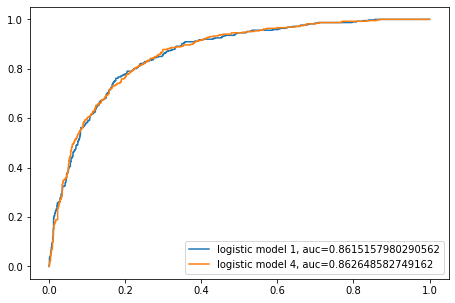

In [ ]:
figure, ax = plt.subplots(1, figsize=(7.5, 5))
plt.subplots_adjust(wspace=0.5, hspace=0.1)

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plot1 = plt.plot(fpr,tpr,label="logistic model 1, auc="+str(auc))
plt.legend(loc=4)
# plt.show()

y_pred_proba_4 = logreg4.predict_proba(X_test3)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_4)
auc = metrics.roc_auc_score(y_test, y_pred_proba_4)
plot2 =plt.plot(fpr,tpr,label="logistic model 4, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Because model 4 uilises 7 less variables, and has sensibly less multicolinearity, we deem this as out best logistic regression model. As we have identified our best logistic regression model, we now check wherther there is severe multicoliinearity in model 4. 

The observations for churn seem to be indipendent of the Index. 

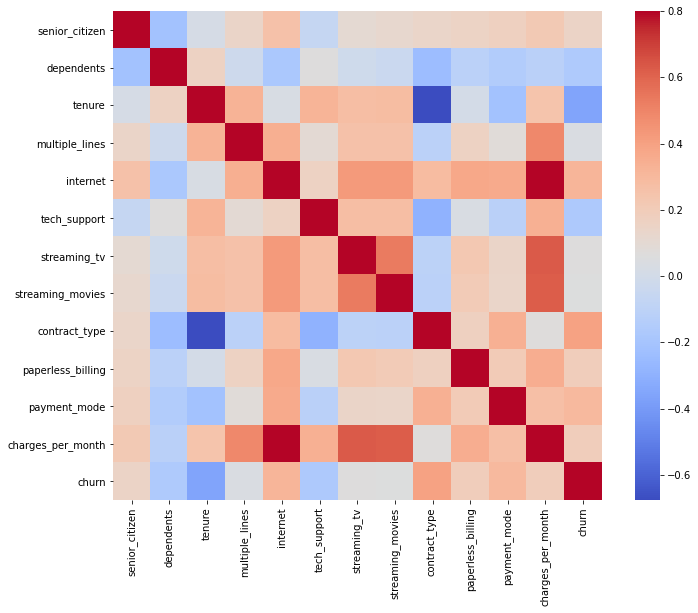

In [ ]:
df_model4 =  pd.DataFrame(df.drop(columns=['gender', 'partner', 'phone_Service', 'security_online','device_protection','backup_online', 'charges_total']))
corrmatrix = df_model4.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmatrix, vmax = 0.8, square = True, cmap = "coolwarm")

As pointed out, some variables seem to be highly correlated, but this is not severe enough to cause high multicolinearity in the model.

### Main takeways
- Our logitistic regression model performs reasonbly well on the test set with accuracy of about 81%, precision of 70.2%, and recall of 56.2%

- The number of false negatives is higher than the one of false positives. In this case, we would like to minmise the number of false negatives instead, although no model seems to achieve a lower number (not retaining a customer has higher cost than wrongly predicitng a customer to churn with consequent misallocation of resources to retain said customer)

- We only detect about 56.4% of the customer that churn. While reucing the number of customer churing by half (with an optimal strategy) would recude costs significantly, we want to increase our ability to detect customer prone to churning, thus we fit a different model.

## Random forest classifier
First, we fit a random forest classifier without worrying about the unbalanced data, to see how it performs compared to the logistic regression model.

In [ ]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_rf=rand_forest.predict(X_test)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
cnf_matrix

array([[933,  87],
       [194, 192]])

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_rf))
print("Precision:", metrics.precision_score(y_test, y_pred_rf))
print("Recall:", metrics.recall_score(y_test, y_pred_rf))
print("F1 metric:", metrics.f1_score(y_test, y_pred_rf))


Accuracy: 0.8001422475106685
Precision: 0.6881720430107527
Recall: 0.49740932642487046
F1 metric: 0.5774436090225564


This Random Forest classifier underperforms compared to the logistic regression model. This might be due to the ublances in the data, to which decision trees  are more sensitive than logistic regression models. We deal with that first by using Sythetic Minority Oversampling (SMOTE), so that we obtain a larger, balanced dataset containing synthetic minorty cases using combinations of the closest minority cases. 

In [ ]:
sm = SMOTE(random_state=27, ratio=1.0)
X_smote, y_smote = sm.fit_sample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(sum(y_smote == 1))
print(sum(y_smote == 0))

4139
4139


In [ ]:
rand_forest.fit(X_smote, y_smote)

y_pred_rf_balanced=rand_forest.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


array([[928,  92],
       [169, 217]])

We can see that SMOTE balanced our training dataset. As we can see, this change yields a better result for this classifier.

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_rf_balanced))
print("Precision:", metrics.precision_score(y_test, y_pred_rf_balanced))
print("Recall:", metrics.recall_score(y_test, y_pred_rf_balanced))
print("F1 metric:", metrics.f1_score(y_test, y_pred_rf_balanced))

Accuracy: 0.7937411095305832
Precision: 0.6632653061224489
Recall: 0.5051813471502591
F1 metric: 0.5735294117647058


We notice that both Random Forest classifiers are outperformed by our logistic regression model. This might mean that the classification is linear with respect to our feature set; if this were not the case, decision trees would outperform our logistic regression, which assumes a linearity between the logodds of chruning probability and the regressors.

## Feature importance in Random Forest model

We use permutation feature importance to extract the importance of each feature in our balanced random forest model, and comare it with the importance of each feature in our logistic regression models. We notice that  the random forest model relies on mostly the same features to predict churn, but values them a bit differently. The most important feature seems to be by far *internet*, which in our case means that fiber optic users are high churn risks. Other important features incluse tenure, contract type and the amount of charges. 

Text(0.5, 0, 'Permutation Importance Balanced Random Forest')

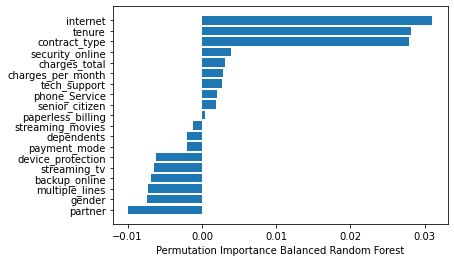

In [ ]:
perm_importance = permutation_importance(rand_forest, X_test, y_test)

importance_sort = perm_importance.importances_mean.argsort()

plt.barh(X_test.columns[importance_sort], perm_importance.importances_mean[importance_sort])

plt.xlabel("Permutation Importance Balanced Random Forest")

## Balanced Bagging classifier

Given the probles with encountered with the Random forest classified, we try to fit a Balanced Baging classifier instead - a bagging classifier that deals with unbalanced data  by undersampling the majority case in each bootstrap sample. This might be beneficial compared to using SMOTE, as it does not involve the synthetic production of minority cases.

In [ ]:
warnings. simplefilter('ignore') # ignoring the wanrings that sklearn will write when using this classifier (new version of the classifier exist)

In [ ]:
Balanced_bag_class = BalancedBaggingClassifier(n_estimators=100)
Balanced_bag_class.fit(X_train, y_train)


BalancedBaggingClassifier(base_estimator=None, bootstrap=True,
                          bootstrap_features=False, max_features=1.0,
                          max_samples=1.0, n_estimators=100, n_jobs=1,
                          oob_score=False, random_state=None, ratio=None,
                          replacement=False, sampling_strategy='auto',
                          verbose=0, warm_start=False)

In [ ]:
y_pred_bagging =Balanced_bag_class.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_bagging)
cnf_matrix

array([[810, 210],
       [108, 278]])

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_bagging))
print("Precision:", metrics.precision_score(y_test, y_pred_bagging))
print("Recall:", metrics.recall_score(y_test, y_pred_bagging))
print("F1 metric:", metrics.f1_score(y_test, y_pred_bagging))

Accuracy: 0.7738264580369844
Precision: 0.569672131147541
Recall: 0.7202072538860104
F1 metric: 0.6361556064073227


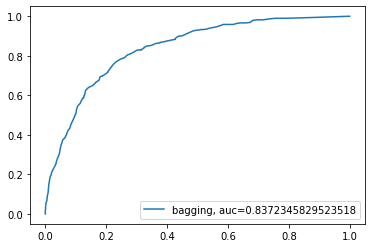

In [ ]:
bagging_probs = Balanced_bag_class.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, bagging_probs)
auc = metrics.roc_auc_score(y_test, bagging_probs)
plt.plot(fpr,tpr,label="bagging, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The Balanced Bagging classifier outperforms both the balanced Random Forest and logistic regression models in recall, by about 15%. Now, the model detects customers who churn 72.1% of the time. We explained before that obtaining a higher recall is more crucial to our business aims and therefore, we deem our bagging model to be the best model to be deployed for churn detection.

Bagging differs with Random Forest in that each feature is selcted in every bootstrap sample, while Random Forest selects a random set of features to be used in each bootstrap sample when fitting the weak learners. Anyways, we cannot provide an exhaustive explanation of why the balanced bagging model outperforms th balanced random forest so clearly. There is to notice that we have also fitted a balanced random forest that would undersample the majority case in each bootrsap sample; however, that model too was outpoerfomred by the Balanced Bagging classifier.

## Bagging model vs logistic regression
The F1 metric for the bagging model is  2.6% higher than the one for our logit model 4, meaning that the trade off between accuracy and recall is overall beneficial to the performance of the model. Let's compare the ROC curves and AUC to better visualise how this trade off plays out.

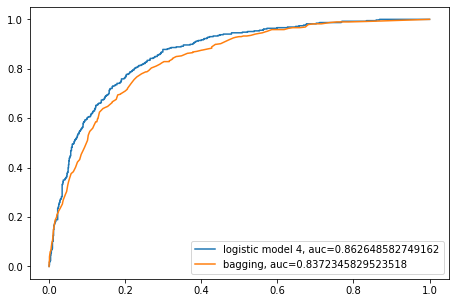

In [ ]:
figure, ax = plt.subplots(1, figsize=(7.5, 5))
plt.subplots_adjust(wspace=0.5, hspace=0.1)

y_pred_proba = logreg4.predict_proba(X_test3)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plot1 = plt.plot(fpr,tpr,label="logistic model 4, auc="+str(auc))
plt.legend(loc=4)

fpr, tpr, _ = metrics.roc_curve(y_test, bagging_probs)
auc = metrics.roc_auc_score(y_test, bagging_probs)
plot2 = plt.plot(fpr,tpr,label="bagging, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The logit model has higher AUC by about 2%, as visible from the ROC curve plot. Yet, and again because of the high acquisition costs related to losing customers, we deem our bagging model to be the best model to be deployed for churn detection, with a solid recall of 72.1%.

## Recommendations for decreasing risk of churn
Having built several models for classifying customers as churn risks, we have learnt that the most important predictors of churn are the amount of time spent with the provider (the longer the customer stays with the company the less likely they are to leave), whether the customer uses fiber-optic internet or not (if they use fiber-optic internet they are more likely to churn), contract type (if a customer is on a month-to-month contract vs 1 or 2-year one, they are more likely to leave), payment mode (those paying by electronic check are bigger churn risks than those using other modes of payment) and their age (i.e. senior citizens are more likely to stay with the same provider). 

Therefore, our recommendations for decreasing churn are: 

- make long-term contracts more financially attractive than month-to-month ones to encourage more signups;

- focus on encouraging loyalty among the younger demographic (offer special promotions tailored to young people's needs, discounted rates, etc.);

- investigate the reasons behind high churn risk amoung fiber-optic internet users (i.e. are there more attractive deals for fiber-optic internet that the customers are switching to, are more tech-adept people simply more likely to change providers, etc.) and those customers who use electronic check as their primary payment mode. 